In [367]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [368]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc("image", cmap="Greys")

## Under the Hood: Training a Digit Classifier
- examine the roles of arrays and tensors
- explain stochastic gradient descent (SGD), the mechanism for learning by updating weights automatically
- discuss the choice of loss function for basic classification

- we will use MNIST a famous dataset of handwritten digits

In [369]:
# download MNIST sample
path = untar_data(URLs.MNIST_SAMPLE)

In [370]:
Path.BASE_PATH = path

In [371]:
# show the directory
path.ls()

# inside the training set is a 3s and 7s directory
(path/"train").ls()

# 3s and 7s are the labels or targets in this dataset

threes = (path/"train"/"3").ls().sorted()
sevens = (path/"train"/"7").ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [372]:
im3_path = threes[1]
# Image class from Python Imaging Library (PIL). Used to open, view and manipulate images
im3 = Image.open(im3_path)
im3

In [373]:
# In a computer everything is a number
# To view the numbers that make up this image convert it to a NumPy or PyTorch tensor
# view a section as a NumPy array
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [374]:
# as a tensor
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [375]:
# slice the array to pick the part with the top of the digit
# use Pandas DataFrame to color code the values using a gradient
# show how the image is created from pixel values

im3_t = tensor(im3)
data_frame = pd.DataFrame(im3_t[4:15, 4:22])
data_frame.style.set_properties(**{"font-size": "6pt"}).background_gradient("Greys")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [376]:
# white pixels stored as 0, black as 255, shades of grey in between

How to create a model that can recognize 3s and 7s?

### Pixel Similarity
- find the average pixel value for every pixel of 3, do the same for 7
- this will give us the average defining the ideal 3 and 7
- classify an image by checking to see which of the two ideal digits the image is most similar to
- seems like a good baseline (simple start)



In [377]:
# get average of pixel values for each of the two groups
# create a tensor of all 3s and 7s stacked together
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)


(6131, 6265)

<AxesSubplot:>

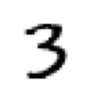

In [378]:
# check that image looks correct
show_image(three_tensors[1])

In [379]:
# combine all images into a single 3d tensor or rank 3 tensor
# use PyTorch stack
# must be a float to do certain operations (ex. mean)

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
# shape shows the length of each axis
stacked_threes.shape

torch.Size([6131, 28, 28])

<AxesSubplot:>

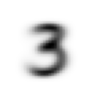

In [380]:
# compute the ideal 3 by calculating the mean of all image tensors
mean3 = stacked_threes.mean(0)
show_image(mean3)

<AxesSubplot:>

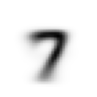

In [381]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

<AxesSubplot:>

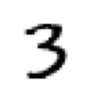

In [382]:
# select an arbitrary 3 and measure its distance from our ideal digit
a_3 = stacked_threes[1]
show_image(a_3)

In [383]:
# we can't add up the differences between pixels of this image and the ideal image
# some may be negative, others positive. If an image is too dark in some and too light in others the result is 0

# instead we could do two things
# take the mean of the absolute value of differences
# take the mean of teh square of differences, then take the square root

# try both
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [384]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [385]:
# our simple model is correct as the distance from 3 is less than the distance from 7
# get the loss, l1 = l1 norm/absolute, mse = mean squared error
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [386]:
# difference between L1 and MSE is the latter will penalize larger mistakes more heavily, more lenient with small mistakes


## NumPy Arrays and PyTorch Tensors
- NumPy widely used library for numeric programming. 
    - similar to PyTorch but does not provide GPU support
    - in this course PyTorch tensors are used over NumPy
- NumPy arrays and PyTorch tensors can finish computations many thousand times faster than using Python
    - wrappers around C
- NumPy array is a multidimensional table of data with items of the same type
- PyTorch tensor is nearly the same but with additional restriction that unlocks capabilities
    - tensor cannot just use any type, it has to be a single basic numeric type for all components
    - can not be jagged or contain different sized arrays within the tensor
- Major benefit of PyTorch tensors is the structures can live on the GPU

In [387]:
data = [[1, 2, 3], [4, 5, 6]]
# numpy
arr = array (data)
# pytorch
tns = tensor (data)

arr, tns

(array([[1, 2, 3],
        [4, 5, 6]]),
 tensor([[1, 2, 3],
         [4, 5, 6]]))

## Computing Metrics Using Broadcasting
- to get a validation set we remove some of the data from training entirely
- MNIST dataset already done for us, valid directory

In [388]:
# create tensors for 3s and 7s in that directory
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/"valid"/"3").ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/"valid"/"7").ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [389]:
# want to write a function is_3 to decide if an image is a 3 or 7
# we do this by deciding which of our two ideal digits is closer
# need to define the notion of distance between two images
def mnist_distance(a,b):
    return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [390]:
# we need to calculate this distance for every image in the validation set
# passing a tensor to an argument meant for a single image will automatically create a tensor of calculations
# also called broadcasting
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1270, 0.1632, 0.1676,  ..., 0.1228, 0.1210, 0.1287]),
 torch.Size([1010]))

In [391]:
# during broadcasting PyTorch doesn't copy mean3 1010 times. It pretends it were a tensor of that shape, but doesn't allocate the memory
# The whole calculation is done in C (or if using a GPU, CUDA (c on the GPU))

# use mnist_distance to figure out whether an image is a 3 or not by using the logic
# distance between the digit, and if the ideal 3 is less than the idea 7 its a 3. If not 7
def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [392]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [393]:
# brodcast to get all the answers
is_3(valid_3_tens)

tensor([ True, False, False,  ...,  True,  True, False])

In [394]:
# calculate the accuracy for each of the 3s and 7s 
# by taking the average of that function for all 3s and its inverse for all 7s
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [395]:
# getting over 90 percent accuracy on both 3s and 7s
# we need to do better and for more digits
# build a system that does real learning and modify itself to improve (SGD)

## Stochastic Gradient Descent (SGD)
- look at each individual pixel and come up with a set of weights for each
- the higher weights are associated with pixels most likely to be black for a particular category
- this is represented as a function and set of weight values for each possible cateogry
- ex. def pr_eight(x,w): return (x*w).sum()
    - x is the image as a vector
    - w is the weights as a vector
- we want the specific values w that causes the result of our function to have the least amount of loss

### Process
- initialize weights
- for each image, use these weights to predict a 3 or 7
- based on predictions calculate the loss
- calculate the gradient for each weight or how changing the weight would change the loss
- step/change all the weights based on that calculation
- go back to step 2
- iterate until you decide to stop the training process (model is good enough)

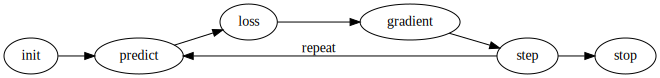

In [396]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

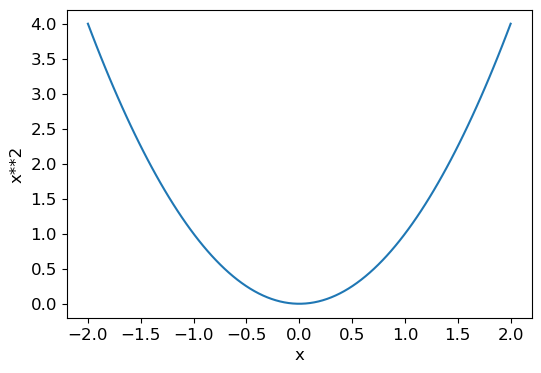

In [397]:
# illustrate a simple example for a quadratic function
def f(x): return x**2
plot_function(f, "x", "x**2")

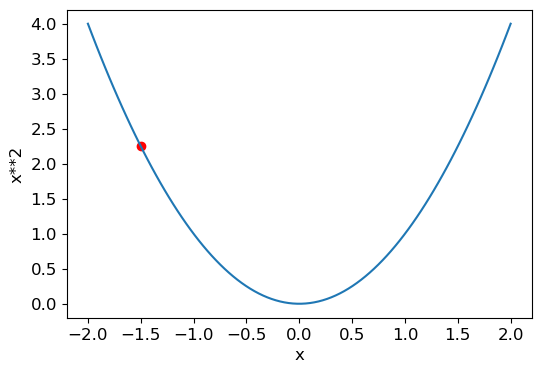

In [398]:
# pick random values to initialize the "weights"
plot_function(f, "x", "x**2")
plt.scatter(-1.5, f(-1.5), color="red")

# next we would see what would happened if we increased or decreased our parameter by a bit (adjustment)
# This is the slope at the particular point
# We change our weight by a little in the direction of the slope, calculate the loss and adjust again
# eventually we get to the lowest point on the curve

## Calculating Gradients
- using derivatives we can determine how rapdily something will change
- gradient is defined as rise/run, change in value of the function divided in change of the value of the parameter
- PyTorch can do the heavy lifting of calculating these values

In [399]:
# pick a tensor value which we want gradients at
# requires_grad_ tells PyTorch we want to calculate gradients with respect to that variable at that value
xt = tensor(3.).requires_grad_()
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [400]:
# calculate the gradients with backpropagation (calculating the derivative at each layer)
yt.backward()

In [401]:
# view the gradients
xt.grad
# derivative of x**2 is 2*x, when x is 3 the derivative is 2*3=6

tensor(6.)

In [402]:
# do the same but with a vector argument
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [403]:
def f(x): return(x**2).sum()
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [404]:
# gradients are 2*xt as expected
yt.backward()
xt.grad
# gradients only tell us slope, not how far to adjust, but gives us an idea of how far

tensor([ 6.,  8., 20.])

## Stepping with a Learning Rate
- at each step we multiply the gradient by some small number (learning rate)
- learning rate is often between 0.001 and 0.1, although it could be anything
- learning rate often just chosen by training a few and finding the best result

- w -= gradient(w) * lr

- this is stepping your parameters using an optimizer step
- we adjust the parameter in the direction of the slope
- the goal is to minimize the loss
- picking too low of a learning rate means a lot more steps
- picking too high can overshoot 

In [405]:
# End to End SGD Example
# imagine you were measuring the speed of a roller coaster as it went over the top of a hump
# you want to build a model of how speed changes over time
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

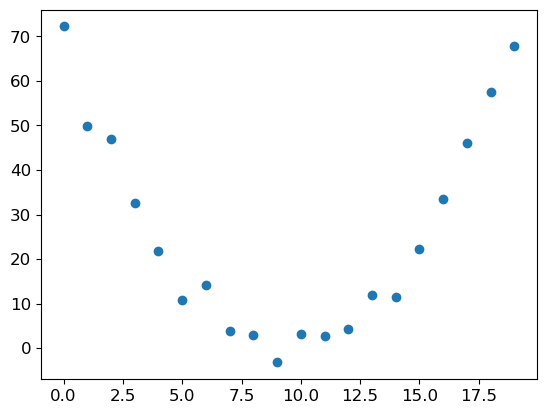

In [406]:
# add random noise
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed)


In [407]:
# first we try to find a function that matches our observation
# try quadratic a*(time**2) + (b*time) + c
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c
# a, b, and c are the weights

In [408]:
# define a loss function
# returns value based on prediction and target
# use mean squared error
def mse(preds, targets):
    return ((preds-targets)**2).mean()

In [409]:
# Step 1: Initialize the parameters
# initialize to random values and tell PyTorch to track the gradients
params = torch.randn(3).requires_grad_()

#keep track of original params
orig_params = params.clone()

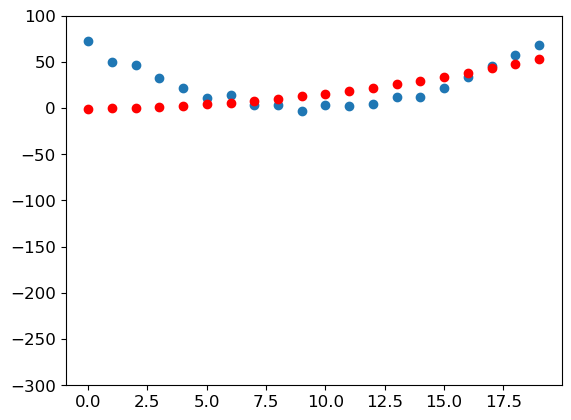

In [410]:
# Step 2: Calculate the predictions
preds = f(time, params)

def show_preds(preds, ax=None):
    if ax is None: 
        ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color="red")
    ax.set_ylim(-300,100)

show_preds(preds)

In [411]:
# Step 3: Calculate the loss
loss = mse(preds, speed)
loss

tensor(674.5057, grad_fn=<MeanBackward0>)

In [412]:
# Step 4: Calculate the gradients
loss.backward()
params.grad

tensor([687.5233,  52.3164, -14.1693])

In [413]:
# use 1e-5 as learning rate
params.grad * 1e-5
params

tensor([ 0.1367,  0.2491, -0.7250], requires_grad=True)

In [414]:
# Step 5: Step the weights
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [415]:
# check if loss has improved
preds = f(time, params)
mse(preds, speed)

tensor(671.0921, grad_fn=<MeanBackward0>)

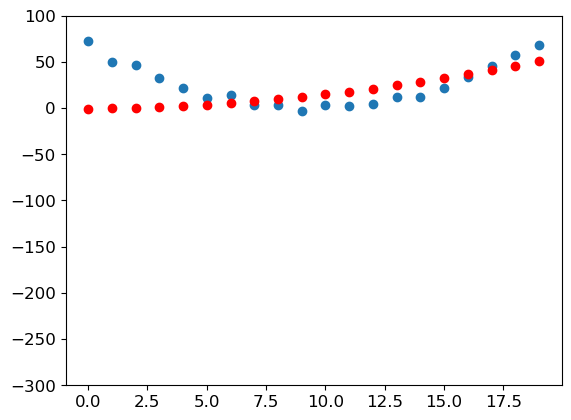

In [416]:
# Getting better
show_preds(preds)

In [417]:
# repeat a few times, create a function to do this for us

def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: 
        print(loss.item())
    return preds

In [418]:
for i in range(10):
    apply_step(params)

671.0921020507812
670.4432373046875
670.3175048828125
670.2907104492188
670.2827758789062
670.2783203125
670.2745361328125
670.2708129882812
670.2672119140625
670.2636108398438


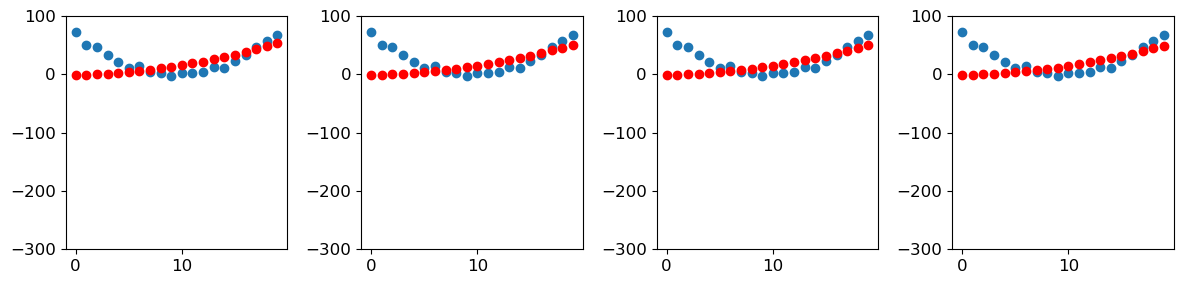

In [419]:
# see how things have changed starting with first params selected
params = orig_params.detach().requires_grad_()

_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

In [420]:
# Step 7: stop
# arbitrarily stopping at 10 epochs (steps)
# in practice we would watch training and validation losses and our metrics to decide when to stop

## The MNIST Loss Function
- we have our independent variables x (images themselves)
- concatenate them into a ginle tensor and change them from a list of matricies (rank 3 tensor) to a list of vectors (rank 2 tensor)
- we can do this using view

In [421]:
# -1 is a special parameter to view that means "make axis as big as necessary to fit all data"
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [422]:
# we need labels for each image. We will use 1 for 3s and 0 for 7s
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [423]:
# dataset in PyTorch is required to return a tuple of (x,y) when indexed
# Python provides a zip function when combined with list to do this
data_set = list(zip(train_x, train_y))
x, y = data_set[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [424]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_data_set = list(zip(valid_x, valid_y))

In [425]:
# now we need a initial random weight for every pixel
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28, 1))
weights[0]

tensor([-1.8813], grad_fn=<SelectBackward0>)

In [426]:
# weights * pixels isn't flexible enough (will always be equal to 0 when pixel = 0)
# formual for a line is y = w*x + b. We need b
bias = init_params(1)
bias

tensor([-0.3181], requires_grad=True)

In [427]:
# weights w and bias b make up the parameters
# calculate a prediction for one image
(train_x[0]*weights.T).sum() + bias

tensor([-0.6044], grad_fn=<AddBackward0>)

In [428]:
# using a for loop to calculate the prediction of each image is too slow
# use matrix multiplication instead
def linear1(xb):
    return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[-0.6044],
        [-0.2609],
        [ 1.2645],
        ...,
        [-3.9615],
        [ 8.1861],
        [-5.6374]], grad_fn=<AddBackward0>)

In [429]:
# check the accuracy
# we check if it's greater than 0
# accuracy for each item can be calculated with broadcasting
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [ True],
        ...,
        [ True],
        [False],
        [ True]])

In [430]:
corrects.float().mean().item()

0.6737657189369202

In [431]:
# lets see what the change in accuracy is for a small change in one of the weights
# we need to ask PyTorch not to calculate gradients while we do this
with torch.no_grad():
    weights[0] *= 1.0001

preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.6737657189369202

In [432]:
# need gradients to improve our model using SGD
# to calculate gradients we need a loss function
# obvious choice is accuracy
# problem is gradient is almost 0 everywhere
# gradient is slope (rise/run) or how much a function value goes up or down, divided by the change
# (y_new - y_old) / (x_new - x_old)
# accuracy only changes when prediction goes from 3 to 7
# a small change in weights isn't likely to cause any prediction change
# so (y_new - y_old) will almost always be 0

# we need a better loss function such that when our weights result in slightly better predictions we get slightly better loss
# loss function will recieve not the images themselves but the prediction from the model
# predictions will be of values between 0 and 1 where each value is the prediction that an image is a 3
# purpose of loss is to measure the difference between predicted values and true values
# targets with values 0 or 1 will tell whether na image is actually a 3 or not

In [433]:
targets = tensor([1,0,1])
predictions = tensor([0.9, 0.4, 0.2])

def mnist_loss(predictions, targets):
    # torch.where(a,b,c) is the same as running the list comprehension [b[i] if a[i] else c[i] for i in range(len(a))]
    # functions measures how distant each prediction is from 1 if it should be 1 or 0 if it should be 0
    return torch.where(targets==1, 1 - predictions, predictions).mean()

In [434]:
torch.where(targets==1, 1 - predictions, predictions)

tensor([0.1000, 0.4000, 0.8000])

In [435]:
# number returns a lower number when predictions are more accurate
# in PyTorch a lower value of a loss function is considered better
# mnist_loss takes the mean of the previous tensor
mnist_loss(predictions, targets)

tensor(0.4333)

In [436]:
# if we change our prediction for the one "false" target from 0.2 to 0.8 the loss will go down
mnist_loss(tensor([0.9, 0.4, 0.8]), targets)

tensor(0.2333)

In [437]:
# problem with mnist_loss is the prediction must always be between 0 and 1
# sigmoid can help with that

In [438]:
# sigmoid function always outputs a number between 0 and 1
def sigmoid(x): 
    return 1/(1 + torch.exp(-x))

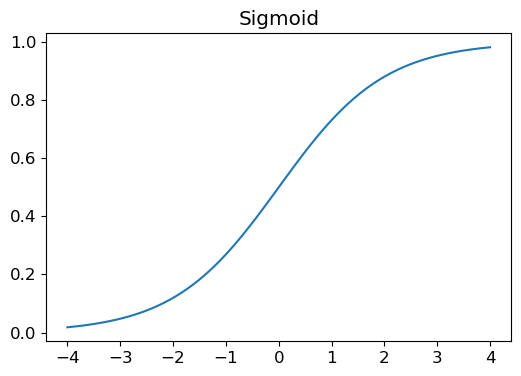

In [439]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [440]:
# any input value positive or negative will be return an output between 0 and 1
# it's also a smooth curve that only goes up, making it easier for SGD to find meaningful gradients

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1 - predictions, predictions).mean()

In [441]:
# loss must always be a fucntion that has a meaningful drivative
# it can not have flat sections and large jumps but instead be smooth
# metrics we ultimatley care about as these are the values printed at the end of each epoch
# overall the focus should be on improving metrics rather than loss when judging the performance of a model

## SGD and Mini-Batches
- now that we have a loss function, next is to change or update the weights based on gradients (optimization step)
- In order to take an optimization step we need to calculate loss over one more more data items
    - How? Calculate the whole dataset? Take the average? Calculate it for a single data item? 
    - neither of these is ideal? 
    - calculating the whole dataset would take too long, calculating a single item would not give us enough information
    - instead we compromise and calculate the average loss for a few data items at a time. Mini Batching
- Larger batch size means more accurate and stable but takes longer
- Choosing a good batch size is one of the important decisions to train a model quickly and accurately
    - also need to consider GPU memory when batching

In [442]:
# DataLoader provides a class that can do the shuffling and mini-batch collation for you
coll = range(15)
data_loader = DataLoader(coll, batch_size=5, shuffle=True)
list(data_loader)

[tensor([ 2,  3, 10, 11,  7]),
 tensor([ 5,  0, 13,  4,  9]),
 tensor([ 8,  6,  1, 12, 14])]

In [443]:
# for training a model we don't just want any Python collection 
# but a collection containing independent and dependent variables
# A collection that contains tuples of independent and dependent variables is known in PyTorch as a Dataset
data_set_example = L(enumerate(string.ascii_lowercase))
data_set_example

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [444]:
# when we pass Dataset to a DataLoader we get back mini-batches
# which are themselves tuples of tensors representing batches of independent and dependent variables
data_loader = DataLoader(data_set_example, batch_size=6, shuffle=True)
list(data_loader)

[(tensor([17, 22, 19,  4, 13, 18]), ('r', 'w', 't', 'e', 'n', 's')),
 (tensor([ 6,  7, 24, 23, 16,  5]), ('g', 'h', 'y', 'x', 'q', 'f')),
 (tensor([21, 20, 12, 14,  8, 15]), ('v', 'u', 'm', 'o', 'i', 'p')),
 (tensor([10,  1, 25,  2,  3,  0]), ('k', 'b', 'z', 'c', 'd', 'a')),
 (tensor([ 9, 11]), ('j', 'l'))]

In [445]:
# Putting it all together


## Putting it all together
Will look something like
```
for x,y in data_loader:
    prediction = model(x)
    loss = loss_function(prediction, y)
    loss.backward()
    parameters -= parameters.grad * learning_rate
```

In [446]:
# re-initialize parameters
weights = init_params((28*28, 1))
bias = init_params(1)

In [447]:
# DataLoader created from Dataset
data_loader = DataLoader(data_set, batch_size=256)
xb, yb = first(data_loader)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [448]:
valid_data_loader = DataLoader(valid_dset, batch_size=256)

In [449]:
# create a mini-batch of size 4 for testing
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [450]:
predictions = linear1(batch)
predictions

tensor([[ 3.0253],
        [ 7.8746],
        [-4.1890],
        [ 0.0419]], grad_fn=<AddBackward0>)

In [451]:
loss = mnist_loss(predictions, train_y[:4])
loss

tensor(0.3803, grad_fn=<MeanBackward0>)

In [452]:
# calculate the gradients
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0131), tensor([-0.0773]))

In [453]:
def calc_grad(xb, yb, model):
    predictions = model(xb)
    loss = mnist_loss(predictions, yb)
    loss.backward()

In [454]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0262), tensor([-0.1546]))

In [455]:
# call it twice
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0393), tensor([-0.2319]))

In [456]:
# gradients changed. The reason is that loss.backward adds the gradients of loss to any gradients currently stored
# we need to set the gradients to 0 first
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [457]:
# update the weights and biases based on the gradient and learning rate
# we have to tell PyTorch not to take the gradient of this step too
def train_epoch(model, learning_rate, params):
    for xb,yb in data_loader:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * learning_rate
            p.grad.zero_()

In [460]:
# to check how we are doing look at the accuracy of the validation set
# we can check whether it's greater than 0
(predictions>0.0).float() == train_y[:4]

tensor([[ True],
        [ True],
        [False],
        [ True]])

In [461]:
# this gives a function to calculate our validation accuracy
def batch_accuracy(xb, yb):
    predictions = xb.sigmoid()
    correct = (predictions>0.5) == yb
    return correct.float().mean()

In [462]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.7500)

In [463]:
# put the batches together
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_data_loader]
    return round(torch.stack(accs).mean().item(), 4)
    

In [464]:
# our starting point
validate_epoch(linear1)

0.3686

In [465]:
# train for one epoch and see if the accuracy improves
learning_rate = 1
params = weights, bias
train_epoch(linear1, learning_rate, params)
validate_epoch(linear1)

0.5041

In [466]:
# try a few more
for i in range(20):
    train_epoch(linear1, learning_rate, params)
    print(validate_epoch(linear1), end=" ")

0.5799 0.6824 0.8558 0.9159 0.9344 0.9466 0.9535 0.9574 0.9603 0.9603 0.9628 0.9637 0.9647 0.9672 0.9672 0.9677 0.9682 0.9682 0.9682 0.9687 

In [467]:
# already same accuracy as our pixel similarity appraoch 
# next step is to create an object that can handle the SGD step for us
# PyTorch has an optimizer

In [468]:
# Creating an Optimizer
# replace our linear1 function with PyTorch's nn.Linear module
# nn.Linear does the same thing as our init_params and linear together
# it contains both the weights and biases in a single class
linear_model = nn.Linear(28*28, 1)

In [469]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [470]:
# use this to create an optimizer
class BasicOptim:
    def __init__(self, params, learning_rate):
        self.params, self.learning_rate = list(params), learning_rate
        
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.learning_rate
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None
        

In [471]:
opt = BasicOptim(linear_model.parameters(), learning_rate)

In [472]:
# training loop is now simplified to
def train_epoch(model):
    for xb, yb in data_loader:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [473]:
# validation stays the same
validate_epoch(linear_model)

0.5349

In [475]:
# create a loop
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=" ")

train_model(linear_model, 20)

0.4932 0.7807 0.8593 0.917 0.9355 0.9496 0.9584 0.9643 0.9662 0.9677 0.9706 0.9721 0.9741 0.975 0.976 0.977 0.9775 0.978 0.978 0.978 

In [476]:
# fastai provides an SGD class which is the same thing as BasicOptim
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), learning_rate)
train_model(linear_model, 20)

0.4932 0.7431 0.8598 0.9184 0.9345 0.9502 0.9579 0.9628 0.9658 0.9672 0.9706 0.9721 0.9741 0.975 0.976 0.9765 0.9775 0.978 0.978 0.9785 

In [478]:
# fast ai also provides Learner.fit which can be used instead of train_model
# first we need to create a DataLoader by passing in training and validation DataLoaders
data_loaders = DataLoaders(data_loader, valid_data_loader)

In [479]:
learner = Learner(data_loaders, nn.Linear(28*28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [482]:
# now we call fit
learner.fit(10, lr=learning_rate)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637064,0.503325,0.495584,00:00
1,0.464807,0.243902,0.780667,00:00
2,0.173150,0.160807,0.853778,00:00
3,0.076962,0.099658,0.916094,00:00
4,0.041539,0.074338,0.935721,00:00
5,0.027693,0.060254,0.948970,00:00
6,0.021987,0.051385,0.955839,00:00
7,0.019433,0.045429,0.962709,00:00
8,0.018122,0.041199,0.965653,00:00
9,0.017324,0.038050,0.967125,00:00


In [ ]:
# now we can replace our linear model with a neural net

## Adding a Nonlinearity
- linear classifier is very constrained in what it can do
- to make it a bit more complex and handle more tasks we need something nonlinear between two linear classifiers

In [483]:
# entire definition of a basic neural network
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

# w1 and w2 are weith tensors. b1 and b2 are bias tensors
# parameters initially randomly initialized just like the previous section
w1 = init_params((28 * 28, 30))
b1 = init_params(30)
w2 = init_params((30, 1))
b2 = init_params(1)

# w1 has 30 output activiations (which means w2 must have 30 input activiations)
# This means the first layer can construct 30 different features
# 30 can be changed to anything you like to make the model more or less complex

# res.max(tensor(0.0)) is called a rectified linear unit or ReLU
# it replaces every negative number with a 0
# also available as F.relu

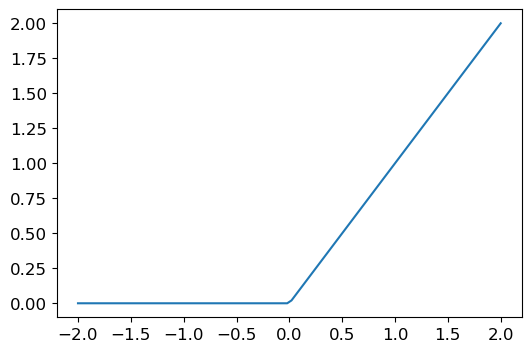

In [484]:
plot_function(F.relu)

In [485]:
# by using more linear layers, we can have a model that does more computation and more complex functions
# two linear functions is another linear function
# adding a nonlinear function such as max makes this no longer true
# if you can find the right parameters for w1 and w2 this little function can solve any computable problem to a high level of accuracy
# universal approximation theorem

In [489]:
# three layers
simple_net = nn.Sequential(nn.Linear(28*28, 30), # linear function
              nn.ReLU(), # nonlinear or activiation function
              nn.Linear(30,1) # linear function
            )

# nn.Sequential creates a module that will call each of the listed layers or functions in turn

In [491]:
learn = Learner(
    data_loaders, 
    simple_net, 
    opt_func=SGD, 
    loss_func=mnist_loss, 
    metrics=batch_accuracy)

In [492]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.324791,0.410604,0.504416,00:00
1,0.150566,0.231259,0.804220,00:00
2,0.083044,0.115736,0.914132,00:00
3,0.054398,0.078154,0.938665,00:00
4,0.041146,0.061049,0.955839,00:00
5,0.034388,0.051427,0.962218,00:00
6,0.030507,0.045357,0.965162,00:00
7,0.027986,0.041203,0.966634,00:00
8,0.026170,0.038181,0.968106,00:00
9,0.024766,0.035873,0.968597,00:00


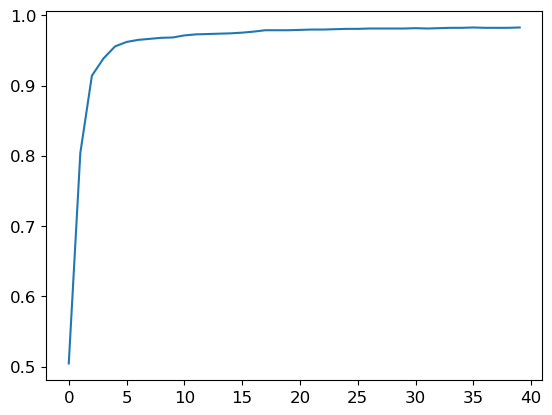

In [493]:
# plot the accuracy over training
plt.plot(L(learn.recorder.values).itemgot(2))

In [494]:
# view the final accuracy
learn.recorder.values[-1][2]

0.982826292514801

In [503]:
# at this point we have
# a function that can solve any problem to any level of accuracy given the correct set of parameters
# a way to find the best set of parameters for any function (SGD)

# It's possible to go deeper but the more layers added the harder it is to optimize the parameters in practice
# If two linear layers is enough for any approximate why go deeper?
    # performance
    # with deeper models we do not need to use as many parameters
    # we can use smaller matrices with more layers to get better results
    # train models more quickly with less memory

# example 18 layer model using the same approach 
data_loaders = ImageDataLoaders.from_folder(path)
learn = vision_learner(data_loaders, resnet18,pretrained=False,
                       loss_func=F.cross_entropy, metrics=accuracy
                      )
learn.fit_one_cycle(1, 0.1)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.150338,0.018258,0.998037,02:39


In [ ]:
# 99.99% accuracy compared to 98% with our simple neural net
# depending on the circumstance this level of accuracy may be needed